<a href="https://www.kaggle.com/code/yorkyong/churn-prediction-ensemble-w-cb-xgb-lgbm?scriptVersionId=158011434" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <p style="background-color:red;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">1. Introduction</p>

In this notebook, we embark on a comprehensive journey to enhance the predictive power of our model through advanced feature engineering and ensemble learning. The ensemble comprises well-known gradient boosting algorithms such as CATBoost, XGBoost, and LGBM, each contributing its unique strengths to the overall predictive capability. 

### Feature Engineering
* We begin by exploring and applying the best feature engineering practices found in public notebooks for this competition, the aim is to extract maximum information from our dataset. 
* Please find the credit and references for each notebook that inspired the feature used below.

### Pipelines
* We will then begin to build and assemble the pipeline of data-processing & engineered features.

### Ensemble Learning
* Subsequently, we delve into the world of ensemble learning, combining the strengths of different models with varying weights. 
* The evaluation is centered around the ROC_AUC score, and we visually dissect the model's performance using Confusion Matrix insights. 

### Tuning using Optuna
* To further elevate our model's performance, we employ Optuna for hyperparameter optimization, focusing not only on weight adjustments but also fine-tuning various parameters for each individual model. 
* The goal is to achieve an optimized and robust predictive model ready to tackle the challenges of our dataset.

# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">2. Import + Load Data</p>

In [1]:
#Basic libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn library
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler,RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import  cross_val_score #Hyperparameter Tuning


#xgboost library
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

#lgb library
import lightgbm as lgb
from lightgbm import LGBMClassifier

#catboost library
from catboost import CatBoostClassifier

import optuna


import warnings
# Set global warning filter
warnings.filterwarnings("ignore")
# Suppress LightGBM warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*num_leaves.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*No further splits with positive gain.*")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
sample = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')
train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv', index_col = 'id')
trainX = train.drop(['Exited'], axis=1)
trainy = train['Exited']
test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv', index_col = 'id')

# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">3. Feature Engineering</p>


## Age Binning

In [3]:
class AgeBinning(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins):
        self.n_bins = n_bins
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        transformed = pd.qcut(X['Age'], self.n_bins, labels=False)
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed, 
                                       name=f'QCut{self.n_bins}_Age',
                                       index=X.index)
        X_copy = X.copy()
        return pd.concat([X_copy, transformed_series], axis=1)
        
AgeBinning(5).fit_transform(train)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,QCut5_Age
id,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,1
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,3
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,1
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,1
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,0


## Credit Score Binning

In [4]:
class CreditScoreBinning(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins):
        self.n_bins = n_bins
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        transformed = pd.qcut(X['CreditScore'], self.n_bins, labels=False)
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed, 
                                       name=f'QCut{self.n_bins}_CreditScore',
                                       index=X.index)
        X_copy = X.copy()
        return pd.concat([X_copy, transformed_series], axis=1)
        
CreditScoreBinning(5).fit_transform(train)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,QCut5_CreditScore
id,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,2
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,2
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,2
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,4
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,0


## Estimated Salary Binning

In [5]:
class SalaryBinning(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins):
        self.n_bins = n_bins
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        transformed = pd.qcut(X['EstimatedSalary'], self.n_bins, labels=False)
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed, 
                                       name=f'QCut{self.n_bins}_Est_Salary',
                                       index=X.index)
        X_copy = X.copy()
        return pd.concat([X_copy, transformed_series], axis=1)
        
SalaryBinning(10).fit_transform(train)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,QCut10_Est_Salary
id,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,9
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,9
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,3
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,5
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,5
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,5


## Balance to Salary Ratio
referenced from: https://www.kaggle.com/code/ashishkumarak/playground-s4e1-bank-churn-prediction-eda#%F0%9F%92%BD-Importing-the-data

In [6]:
class BalanceSalaryRatioTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Balance_Salary_Ratio'] = X_copy['Balance'] / X_copy['EstimatedSalary']
        
        return X_copy

BalanceSalaryRatioTransformer().fit_transform(train)        

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_Salary_Ratio
id,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.000000
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0.000000
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.000000
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1.760655
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,0.000000
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,0.000000
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,0.000000


## Geography and Gender interaction
referenced from: https://www.kaggle.com/code/ashishkumarak/playground-s4e1-bank-churn-prediction-eda#%F0%9F%92%BD-Importing-the-data

In [7]:
class GeoGenderTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Geo_Gender'] = X_copy['Geography'] + '_' + X_copy['Gender']
        return X_copy
    
GeoGenderTransformer().fit_transform(train)   

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geo_Gender
id,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,France_Male
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,France_Male
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,France_Male
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,France_Male
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,Spain_Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,Spain_Female
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,France_Male
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,France_Male


## Total Prouducts Used
referenced from: https://www.kaggle.com/code/ashishkumarak/playground-s4e1-bank-churn-prediction-eda#%F0%9F%92%BD-Importing-the-data

In [8]:
class TotalProductsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Total_Products_Used'] = X_copy['NumOfProducts'] + X_copy['HasCrCard']
        return X_copy

TotalProductsTransformer().fit_transform(train)   

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Total_Products_Used
id,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,3.0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,3.0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,3.0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,2.0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,2.0
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,1.0
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,2.0


## Gender and Total Product interaction
referenced from: https://www.kaggle.com/code/ashishkumarak/playground-s4e1-bank-churn-prediction-eda#%F0%9F%92%BD-Importing-the-data

In [9]:
class TpGenderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, total_products_field='Total_Products_Used', gender_field='Gender'):
        self.total_products_field = total_products_field
        self.gender_field = gender_field
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Tp_Gender'] = X_copy[self.total_products_field].astype('str') + X_copy[self.gender_field]
        return X_copy

train_tp = TotalProductsTransformer().fit_transform(train)   
TpGenderTransformer().fit_transform(train_tp)    

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Total_Products_Used,Tp_Gender
id,,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,3.0,3.0Male
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,3.0,3.0Male
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,3.0,3.0Male
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,2.0,2.0Male
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,3.0,3.0Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,2.0,2.0Female
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,1.0,1.0Male
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,2.0,2.0Male


## TFIDF-PCA (Text Transformation)
referenced from: https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble#TFIDF-PCA-(Text-Transformation)

In [10]:
class TFIDFPCATransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, max_features, n_components):
        self.column = column
        self.max_features = max_features
        self.n_components = n_components
        self.vectorizer = TfidfVectorizer(max_features=max_features)
        self.svd = TruncatedSVD(n_components=n_components)

    def fit(self, X, y=None):
        vectors = self.vectorizer.fit_transform(X[self.column])
        self.svd.fit(vectors)
        return self

    def transform(self, X):
        vectors = self.vectorizer.transform(X[self.column])
        svd_result = self.svd.transform(vectors)

        tfidf_df = pd.DataFrame(svd_result, columns=[f"{self.column}_tfidf_{i}" for i in range(self.n_components)])
        X = pd.concat([X, tfidf_df], axis="columns")
        return X
    
TFIDFPCATransformer(column="Surname", max_features=1000, n_components=5).fit_transform(train) 

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Surname_tfidf_3,Surname_tfidf_4
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,-2.795137e-07,2.693988e-07,1.239702e-06,-6.745719e-06,9.560290e-06
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,-2.560196e-07,-1.476410e-07,5.043479e-07,-5.578702e-06,1.091761e-05
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,9.018772e-04,-2.554068e-03,-1.536913e-03,4.747215e-03,-2.447892e-02
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,-1.050428e-03,3.639808e-03,1.758454e-03,-1.008908e-02,5.529748e-02
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,6.332789e-08,-4.967779e-08,6.797934e-07,-2.247818e-06,3.161629e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,-9.306931e-11,5.629748e-11,-5.736310e-11,3.173317e-10,6.986955e-11
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,-7.751879e-07,4.062036e-06,5.445691e-07,-1.019905e-05,2.025224e-05
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,1.388274e-04,9.999529e-01,3.650885e-03,-5.255646e-04,1.413259e-03
165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,2.027307e-04,1.635192e-04,-9.521125e-04,-8.094910e-03,6.496395e-03


## k-Means Clusterer
with reference: https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble#4.3-Numerical-Clustering

In [11]:
class KMeansClusterer(BaseEstimator, TransformerMixin):
    def __init__(self, features, n_clusters=20, random_state=0, n_components=None):
        self.features = features
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.n_components = n_components
        self.kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=random_state)
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=n_components)
    
    def fit(self, X, y=None):
        X_scaled = self.scaler.fit_transform(X.loc[:, self.features])
        if self.n_components is not None:
            X_scaled = self.pca.fit_transform(X_scaled)
        self.kmeans.fit(X_scaled)
        return self
    
    def transform(self, X):
        X_scaled = self.scaler.transform(X.loc[:, self.features])
        
        # Check for NaN values and replace them with zeros or appropriate values
        if np.isnan(X_scaled).any():
            X_scaled = np.nan_to_num(X_scaled)
        
        if self.n_components is not None:
            X_scaled = self.pca.transform(X_scaled)
        
        X_new = pd.DataFrame()
        X_new["Cluster"] = self.kmeans.predict(X_scaled)
        
        X_copy = X.copy()
        # Convert the "Cluster" column to dense format
        X_new["Cluster"] = X_new["Cluster"].values
        return pd.concat([X_copy.reset_index(drop=True), X_new.reset_index(drop=True)], axis=1)


In [12]:
#With PCA (specify the number of components, e.g., 3)
clusterer_with_pca = KMeansClusterer(features=["CustomerId","EstimatedSalary","Balance"], n_clusters=10, random_state=123, n_components=3)

# Fit and transform your data
clusterer_with_pca.fit_transform(train)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Cluster
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,3
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,3
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,7
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,3
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,3
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,3
165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,5


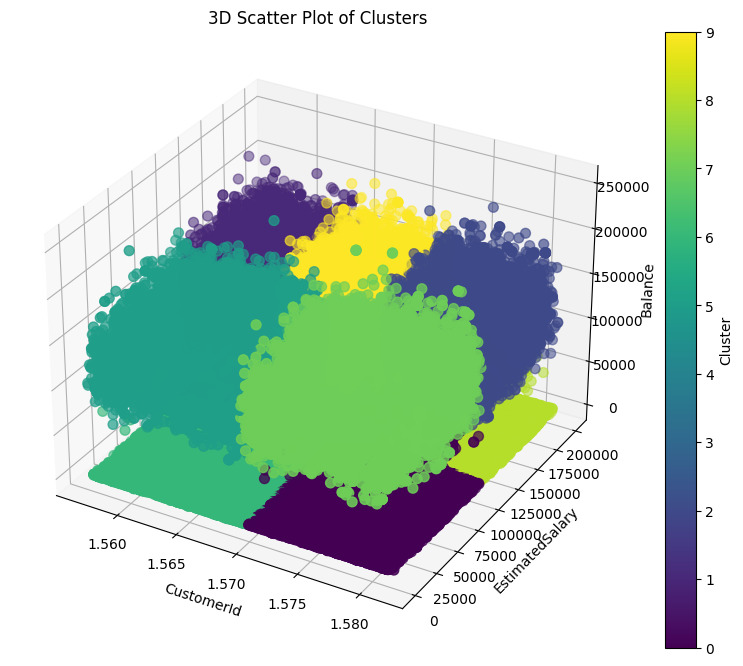

In [13]:
#Visualising the clusters
from mpl_toolkits.mplot3d import Axes3D

# Assuming X_train is your training data
X_train_selected = train[["CustomerId","EstimatedSalary","Balance"]]

# Fit and transform with PCA and KMeansClusterer
clusterer_with_pca.fit(X_train_selected)
X_transformed = clusterer_with_pca.transform(X_train_selected)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of data points colored by cluster
scatter = ax.scatter(X_transformed["CustomerId"], X_transformed["EstimatedSalary"], X_transformed["Balance"], c=X_transformed["Cluster"], cmap='viridis', s=50)

# Add labels and title
ax.set_xlabel("CustomerId")
ax.set_ylabel("EstimatedSalary")
ax.set_zlabel('Balance')
ax.set_title('3D Scatter Plot of Clusters')

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

plt.show()

# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">4. Assembling the Pipeline</p>

## Column Transformer

In [14]:
#applies transformers to different columns.
multicolumn_prep = ColumnTransformer([ ('encode', 
                                       OneHotEncoder(handle_unknown='ignore'), 
                                       ['Gender', 'Geography','NumOfProducts','HasCrCard','IsActiveMember','Geo_Gender','Tp_Gender']),
                                     ],
                                     remainder='passthrough')
multicolumn_prep

ColumnTransformer(remainder='passthrough',
                  transformers=[('encode',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Gender', 'Geography', 'NumOfProducts',
                                  'HasCrCard', 'IsActiveMember', 'Geo_Gender',
                                  'Tp_Gender'])])

## Drop Columns

In [15]:
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        
        return X.drop(self.cols, axis=1)

In [16]:
named_preprocessing_pipeline = Pipeline([
    ('kmeans', KMeansClusterer(features=["CustomerId","EstimatedSalary","Balance"], n_clusters=10, random_state=123, n_components=3)),
    ('surname_tfid', TFIDFPCATransformer(column="Surname", max_features=1000, n_components=5)),
    ('age_binning', AgeBinning(5)),
    ('salary_binning', SalaryBinning(10)),
    ('balance_salary_ratio', BalanceSalaryRatioTransformer()),
    ('geo_gender', GeoGenderTransformer()),
    ('total_products', TotalProductsTransformer()),
    ('tp_gender', TpGenderTransformer()),
    ('drop', DropColumn(cols=['CustomerId','Surname'])),
    ('prep',ColumnTransformer([ ('encode', 
                                 OneHotEncoder(handle_unknown='ignore',sparse_output=False), 
                                 ['Gender', 'Geography','NumOfProducts','HasCrCard','IsActiveMember','Geo_Gender','Tp_Gender']),
                              ],
                              remainder='passthrough').set_output(transform='pandas')),
])

named_preprocessing_pipeline                               

Pipeline(steps=[('kmeans',
                 KMeansClusterer(features=['CustomerId', 'EstimatedSalary',
                                           'Balance'],
                                 n_clusters=10, n_components=3,
                                 random_state=123)),
                ('surname_tfid',
                 TFIDFPCATransformer(column='Surname', max_features=1000,
                                     n_components=5)),
                ('age_binning', AgeBinning(n_bins=5)),
                ('salary_binning', SalaryBinning(n_bins=10)),
                ('balance_salary_ratio', BalanceSalaryRa...
                ('total_products', TotalProductsTransformer()),
                ('tp_gender', TpGenderTransformer()),
                ('drop', DropColumn(cols=['CustomerId', 'Surname'])),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Geography',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'Geo_Gender',
                                                   'Tp_Gender'])]))])

In [17]:
#checking output on train df
df_train = named_preprocessing_pipeline.fit_transform(train.drop(['Exited'], axis=1))
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 44 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   encode__Gender_Female              165034 non-null  float64
 1   encode__Gender_Male                165034 non-null  float64
 2   encode__Geography_France           165034 non-null  float64
 3   encode__Geography_Germany          165034 non-null  float64
 4   encode__Geography_Spain            165034 non-null  float64
 5   encode__NumOfProducts_1            165034 non-null  float64
 6   encode__NumOfProducts_2            165034 non-null  float64
 7   encode__NumOfProducts_3            165034 non-null  float64
 8   encode__NumOfProducts_4            165034 non-null  float64
 9   encode__HasCrCard_0.0              165034 non-null  float64
 10  encode__HasCrCard_1.0              165034 non-null  float64
 11  encode__IsActiveMember_0.0         1650

In [18]:
#checking output on test df
df_test = pd.DataFrame(named_preprocessing_pipeline.transform(test))
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 44 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   encode__Gender_Female              110023 non-null  float64
 1   encode__Gender_Male                110023 non-null  float64
 2   encode__Geography_France           110023 non-null  float64
 3   encode__Geography_Germany          110023 non-null  float64
 4   encode__Geography_Spain            110023 non-null  float64
 5   encode__NumOfProducts_1            110023 non-null  float64
 6   encode__NumOfProducts_2            110023 non-null  float64
 7   encode__NumOfProducts_3            110023 non-null  float64
 8   encode__NumOfProducts_4            110023 non-null  float64
 9   encode__HasCrCard_0.0              110023 non-null  float64
 10  encode__HasCrCard_1.0              110023 non-null  float64
 11  encode__IsActiveMember_0.0         1100

In [19]:
class RobustScalerNamed(RobustScaler, TransformerMixin):
    def get_feature_names_out(self, X, y=None):
        return X.columns.tolist()

    def transform(self, X, y=None):
        transformed = super().transform(X, y)
        return pd.DataFrame(transformed, columns=X.columns)

In [20]:
modelling_pipeline = Pipeline(named_preprocessing_pipeline.steps + [('scale',RobustScaler().set_output(transform='pandas')),])
modelling_pipeline

Pipeline(steps=[('kmeans',
                 KMeansClusterer(features=['CustomerId', 'EstimatedSalary',
                                           'Balance'],
                                 n_clusters=10, n_components=3,
                                 random_state=123)),
                ('surname_tfid',
                 TFIDFPCATransformer(column='Surname', max_features=1000,
                                     n_components=5)),
                ('age_binning', AgeBinning(n_bins=5)),
                ('salary_binning', SalaryBinning(n_bins=10)),
                ('balance_salary_ratio', BalanceSalaryRa...
                ('total_products', TotalProductsTransformer()),
                ('tp_gender', TpGenderTransformer()),
                ('drop', DropColumn(cols=['CustomerId', 'Surname'])),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Geography',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'Geo_Gender',
                                                   'Tp_Gender'])])),
                ('scale', RobustScaler())])

In [21]:
# modelling_pipeline.fit_transform(train.drop(['Exited'], axis=1))

# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">5. Setting up the Models</p>

# XGBoost Classifier

In [22]:
X = train.drop(['Exited'], axis=1) 
y = train['Exited']

In [23]:
# #XGBoost parameters
# xgb_params_1 = {'max_depth': 8,
#  'min_child_weight': 9, 
#  'learning_rate': 0.015784217705381666,
#  'n_estimators': 928, 
#  'subsample': 0.8311128887439883,
#  'colsample_bytree': 0.3454344427319984,
#  'random_state': 42}


#XGBoost best parameters {'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.07353564842520434, 'n_estimators': 463, 'subsample': 0.8131149969184862, 'colsample_bytree': 0.6598001508811656, 'random_state': 42}
xgb_params_optuna = {'max_depth': 5,
 'min_child_weight': 2, 
 'learning_rate': 0.07353564842520434,
 'n_estimators': 463, 
 'subsample': 0.8131149969184862,
 'colsample_bytree': 0.6598001508811656,
 'random_state': 42}


# XGBoost model
xgb_model = XGBClassifier(**xgb_params_optuna )

xgb_pipeline = make_pipeline(modelling_pipeline, xgb_model)
xgb_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('kmeans',
                                  KMeansClusterer(features=['CustomerId',
                                                            'EstimatedSalary',
                                                            'Balance'],
                                                  n_clusters=10, n_components=3,
                                                  random_state=123)),
                                 ('surname_tfid',
                                  TFIDFPCATransformer(column='Surname',
                                                      max_features=1000,
                                                      n_components=5)),
                                 ('age_binning', AgeBinning(n_bins=5)),
                                 ('salary_binning', SalaryBinning(n_bins=10)),
                                 ('balance_s...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.07353564842520434, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=2, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=463, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [24]:
# # number of folds
# n_splits = 10

# #  StratifiedKFold
# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# #  cross-validation results
# cv_results = []

# # stratified k-fold cross-validation
# for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

#     xgb_pipeline.fit(X_train, y_train )

#     # predictions on the validation set
#     y_val_pred_prob = xgb_pipeline.predict(X_val)
#     y_pred = xgb_pipeline.predict(X_val)
        
#     f1=  f1_score(y_val, y_pred, average='weighted')

#     # Evaluating the model
    
#     roc_auc = roc_auc_score(y_val, y_val_pred_prob)
#     print(f'Fold {fold + 1}, AUC Score on Validation Set: {roc_auc}')
#     print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
#     print('-'*70)

#     # results
#     cv_results.append(roc_auc)

# # average cross-validation result
# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage AUC-score across {n_splits} folds: {average_cv_result}')

**#Results from XGBoost xgb_params_1:**

Fold 1, AUC Score on Validation Set: 0.7569989143865439
Fold 1, F1 Score on Validation Set: 0.862150686851945
----------------------------------------------------------------------
Fold 2, AUC Score on Validation Set: 0.7475693421069775
Fold 2, F1 Score on Validation Set: 0.8561288741919352
----------------------------------------------------------------------
Fold 3, AUC Score on Validation Set: 0.751700650628603
Fold 3, F1 Score on Validation Set: 0.8580091346466167
----------------------------------------------------------------------
Fold 4, AUC Score on Validation Set: 0.7539519677496345
Fold 4, F1 Score on Validation Set: 0.8596911149871906
----------------------------------------------------------------------
Fold 5, AUC Score on Validation Set: 0.7532216329772243
Fold 5, F1 Score on Validation Set: 0.8595033916426605
----------------------------------------------------------------------
Fold 6, AUC Score on Validation Set: 0.7574550981313459
Fold 6, F1 Score on Validation Set: 0.8636823255903835
----------------------------------------------------------------------
Fold 7, AUC Score on Validation Set: 0.7585089249091636
Fold 7, F1 Score on Validation Set: 0.862101549497247
----------------------------------------------------------------------
Fold 8, AUC Score on Validation Set: 0.7508822827948121
Fold 8, F1 Score on Validation Set: 0.8595069201886906
----------------------------------------------------------------------
Fold 9, AUC Score on Validation Set: 0.7559731707323515
Fold 9, F1 Score on Validation Set: 0.8599400101151297
----------------------------------------------------------------------
Fold 10, AUC Score on Validation Set: 0.7530089857881291
Fold 10, F1 Score on Validation Set: 0.8603447658925775
----------------------------------------------------------------------

Average AUC-score across 10 folds: 0.7539270970204786

**#Results from XGBoost xgb_params_optuna:**

Fold 1, AUC Score on Validation Set: 0.7597331514235339
Fold 1, F1 Score on Validation Set: 0.8628078396344337
----------------------------------------------------------------------
Fold 2, AUC Score on Validation Set: 0.752321894073283
Fold 2, F1 Score on Validation Set: 0.8571121897262545
----------------------------------------------------------------------
Fold 3, AUC Score on Validation Set: 0.7573406555020672
Fold 3, F1 Score on Validation Set: 0.8607201523121252
----------------------------------------------------------------------
Fold 4, AUC Score on Validation Set: 0.7547156744178872
Fold 4, F1 Score on Validation Set: 0.8588622113762977
----------------------------------------------------------------------
Fold 5, AUC Score on Validation Set: 0.7548834900735591
Fold 5, F1 Score on Validation Set: 0.8591736079816966
----------------------------------------------------------------------
Fold 6, AUC Score on Validation Set: 0.7648858974998951
Fold 6, F1 Score on Validation Set: 0.8654441741623222
----------------------------------------------------------------------
Fold 7, AUC Score on Validation Set: 0.7629786757227098
Fold 7, F1 Score on Validation Set: 0.8633988981641136
----------------------------------------------------------------------
Fold 8, AUC Score on Validation Set: 0.7535395968148548
Fold 8, F1 Score on Validation Set: 0.860076492469789
----------------------------------------------------------------------
Fold 9, AUC Score on Validation Set: 0.7577292515637706
Fold 9, F1 Score on Validation Set: 0.8594787766025463
----------------------------------------------------------------------
Fold 10, AUC Score on Validation Set: 0.7591622182763144
Fold 10, F1 Score on Validation Set: 0.8630214303703939
----------------------------------------------------------------------

Average AUC-score across 10 folds: 0.7577290505367875

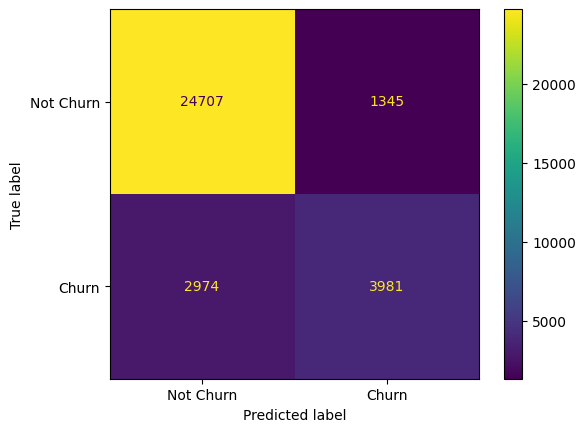

In [25]:
# Assuming trainX and trainy are your features and target variable
X_train, X_val, y_train, y_val = train_test_split(trainX, trainy, test_size=0.2, random_state=42)

xgb_pipeline.fit(X = X_train,
                y = y_train)

predictions_xgb = xgb_pipeline.predict(X_val)

cm_xgb = confusion_matrix(y_val, predictions_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Not Churn', 'Churn'])
disp.plot()
plt.show()

**#Confusion Matrix from XGBoost xgb_params_1:**

* 24754 | 1298
* 3021 | 3934

# LGBM Classifier
* enable GPU Accelerator: GPU P100

In [26]:
# #LGBM parameters
# lgbm_params_1 = {
#     'min_child_samples': 12, 
#     'learning_rate': 0.02849773542504347,
#     'n_estimators': 410, 
#     'subsample': 0.31556535683131615, 
#     'colsample_bytree': 0.9691366837955018, 
#     'reg_alpha': 0.7109904579556621,
#     'reg_lambda': 0.8470259353827624,
#     'device': 'gpu',
#     'verbosity': 0
# }

#LGBM Best parameters:  {'max_depth': 5, 'min_child_samples': 19, 'learning_rate': 0.0617049347085071, 'n_estimators': 637, 'subsample': 0.7452068722516583, 'colsample_bytree': 0.5621023734368561, 'reg_alpha': 0.5354115365654548, 'reg_lambda': 0.25902660973347336}
lgbm_params_optuna = {
    'num_leaves': 31, # condition 2^max_depth > num_leaves
    'max_depth': 5, 
    'min_child_samples': 19, 
    'learning_rate': 0.0617049347085071, 
    'n_estimators': 637, 
    'subsample': 0.7452068722516583, 
    'colsample_bytree': 0.5621023734368561, 
    'reg_alpha': 0.5354115365654548, 
    'reg_lambda': 0.25902660973347336,
    'device': 'gpu',
    'verbosity': 0
}   
  

# lgbm model
lgbm_model = LGBMClassifier(**lgbm_params_optuna)

lgbm_pipeline = make_pipeline(modelling_pipeline, lgbm_model)
lgbm_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('kmeans',
                                  KMeansClusterer(features=['CustomerId',
                                                            'EstimatedSalary',
                                                            'Balance'],
                                                  n_clusters=10, n_components=3,
                                                  random_state=123)),
                                 ('surname_tfid',
                                  TFIDFPCATransformer(column='Surname',
                                                      max_features=1000,
                                                      n_components=5)),
                                 ('age_binning', AgeBinning(n_bins=5)),
                                 ('salary_binning', SalaryBinning(n_bins=10)),
                                 ('balance_s...
                                                                    'HasCrCard',
                                                                    'IsActiveMember',
                                                                    'Geo_Gender',
                                                                    'Tp_Gender'])])),
                                 ('scale', RobustScaler())])),
                ('lgbmclassifier',
                 LGBMClassifier(colsample_bytree=0.5621023734368561,
                                device='gpu', learning_rate=0.0617049347085071,
                                max_depth=5, min_child_samples=19,
                                n_estimators=637, reg_alpha=0.5354115365654548,
                                reg_lambda=0.25902660973347336,
                                subsample=0.7452068722516583, verbosity=0))])

In [27]:
# # folds
# n_splits = 10

# # StratifiedKFold
# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# cv_results = []


# for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):

#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

#     lgbm_pipeline.fit(X_train,y_train)

#     y_val_pred_prob = lgbm_pipeline.predict_proba(X_val)
#     y_pred = lgbm_pipeline.predict(X_val)
        
#     f1=  f1_score(y_val, y_pred, average='weighted')

#     # Evaluating the model
#     logloss = log_loss(y_val, y_val_pred_prob)
#     roc_auc = roc_auc_score(y_val, y_pred)
#     print(f'Fold {fold + 1}, AUC-Score on Validation Set: {roc_auc}')
#     print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
#     print('-'*70)

#     cv_results.append(roc_auc)
# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage AUC-SCORE across {n_splits} folds: {average_cv_result}')

**#Results from LGBM lgbm_params_1:**

Fold 1, AUC-Score on Validation Set: 0.7552560082877062
Fold 1, F1 Score on Validation Set: 0.8604630349773879
----------------------------------------------------------------------
Fold 2, AUC-Score on Validation Set: 0.7503593915775693
Fold 2, F1 Score on Validation Set: 0.8566372125290799
----------------------------------------------------------------------
Fold 3, AUC-Score on Validation Set: 0.7527830068922193
Fold 3, F1 Score on Validation Set: 0.857756742748157
----------------------------------------------------------------------
Fold 4, AUC-Score on Validation Set: 0.7535119648038129
Fold 4, F1 Score on Validation Set: 0.8593270347254924
----------------------------------------------------------------------
Fold 5, AUC-Score on Validation Set: 0.7544576344467713
Fold 5, F1 Score on Validation Set: 0.8594638235981709
----------------------------------------------------------------------
Fold 6, AUC-Score on Validation Set: 0.7591516866114609
Fold 6, F1 Score on Validation Set: 0.862878698187448
----------------------------------------------------------------------
Fold 7, AUC-Score on Validation Set: 0.7607156223348945
Fold 7, F1 Score on Validation Set: 0.8621379443708285
----------------------------------------------------------------------
Fold 8, AUC-Score on Validation Set: 0.7565464696670884
Fold 8, F1 Score on Validation Set: 0.8616356267212724
----------------------------------------------------------------------
Fold 9, AUC-Score on Validation Set: 0.7560494675269485
Fold 9, F1 Score on Validation Set: 0.858651205415433
----------------------------------------------------------------------
Fold 10, AUC-Score on Validation Set: 0.7551319911436293
Fold 10, F1 Score on Validation Set: 0.8606642315432346
----------------------------------------------------------------------

Average AUC-SCORE across 10 folds: 0.7553963243292101

**#Results from LGBM lgbm_params_optuna:**

Fold 1, AUC-Score on Validation Set: 0.7583639861556996
Fold 1, F1 Score on Validation Set: 0.8615204523633316
----------------------------------------------------------------------
Fold 2, AUC-Score on Validation Set: 0.7535757811363835
Fold 2, F1 Score on Validation Set: 0.8582341247554874
----------------------------------------------------------------------
Fold 3, AUC-Score on Validation Set: 0.7566526396111933
Fold 3, F1 Score on Validation Set: 0.8602634113521627
----------------------------------------------------------------------
Fold 4, AUC-Score on Validation Set: 0.7544716781851415
Fold 4, F1 Score on Validation Set: 0.859280107948996
----------------------------------------------------------------------
Fold 5, AUC-Score on Validation Set: 0.757810368493379
Fold 5, F1 Score on Validation Set: 0.8615018421763547
----------------------------------------------------------------------
Fold 6, AUC-Score on Validation Set: 0.7644532078460704
Fold 6, F1 Score on Validation Set: 0.8661226520981758
----------------------------------------------------------------------
Fold 7, AUC-Score on Validation Set: 0.7617179132856391
Fold 7, F1 Score on Validation Set: 0.8626510429845082
----------------------------------------------------------------------
Fold 8, AUC-Score on Validation Set: 0.7570039202884369
Fold 8, F1 Score on Validation Set: 0.861769680711979
----------------------------------------------------------------------
Fold 9, AUC-Score on Validation Set: 0.758557324347017
Fold 9, F1 Score on Validation Set: 0.8608940608717451
----------------------------------------------------------------------
Fold 10, AUC-Score on Validation Set: 0.756312197899689
Fold 10, F1 Score on Validation Set: 0.8607971518717791
----------------------------------------------------------------------
Average AUC-SCORE across 10 folds: 0.757891901724865

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

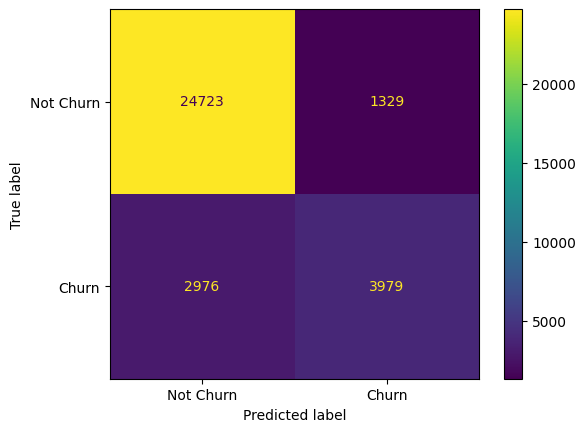

In [28]:
# Assuming trainX and trainy are your features and target variable
X_train, X_val, y_train, y_val = train_test_split(trainX, trainy, test_size=0.2, random_state=42)

lgbm_pipeline.fit(X = X_train,
                y = y_train)

predictions_lgbm = lgbm_pipeline.predict(X_val)

cm_lgbm = confusion_matrix(y_val, predictions_lgbm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm, display_labels=['Not Churn', 'Churn'])
disp.plot()
plt.show()

**#Confusion Matrix from LGBM lgbm_params_1:**

* 24751 | 1301
* 2997 | 3958

**#Confusion Matrix from LGBM lgbm_params_optuna:**

* 24733 | 1319
* 2974 | 3981

# CatBoost Classifier

In [29]:
#catboost parameters
catboost_params_1 = {
    'iterations': 848, 
    'depth': 28,
    'min_data_in_leaf': 5,
    'learning_rate': 0.027876808218320774,
    'grow_policy': 'Lossguide',
    'bootstrap_type': 'Bernoulli',
    'eval_metric': 'AUC',  
}


# #catboost Best parameters: {'iterations': 440, 'depth': 7, 'min_data_in_leaf': 25, 'learning_rate': 0.0003089932009656744}. Best is trial 0 with value: 0.8935675084898207.
# catboost_params_optuna = {
#     'iterations': 440, 
#     'depth': 7,
#     'min_data_in_leaf': 25,
#     'learning_rate': 0.0003089932009656744,
#     'grow_policy': 'Lossguide',
#     'bootstrap_type': 'Bernoulli',
#     'eval_metric': 'AUC',  
# }



# catboost model
cb_model = CatBoostClassifier(**catboost_params_1, random_state=42, verbose=0)


cb_pipeline = make_pipeline(modelling_pipeline, cb_model)
cb_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('kmeans',
                                  KMeansClusterer(features=['CustomerId',
                                                            'EstimatedSalary',
                                                            'Balance'],
                                                  n_clusters=10, n_components=3,
                                                  random_state=123)),
                                 ('surname_tfid',
                                  TFIDFPCATransformer(column='Surname',
                                                      max_features=1000,
                                                      n_components=5)),
                                 ('age_binning', AgeBinning(n_bins=5)),
                                 ('salary_binning', SalaryBinning(n_bins=10)),
                                 ('balance_s...
                                  DropColumn(cols=['CustomerId', 'Surname'])),
                                 ('prep',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['Gender',
                                                                    'Geography',
                                                                    'NumOfProducts',
                                                                    'HasCrCard',
                                                                    'IsActiveMember',
                                                                    'Geo_Gender',
                                                                    'Tp_Gender'])])),
                                 ('scale', RobustScaler())])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7827d29172b0>)])

In [30]:
# n_splits = 10

# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


# cv_results = []


# for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

    
#     cb_pipeline.fit(X_train,y_train)

#     y_val_pred_prob = cb_pipeline.predict_proba(X_val)
#     y_pred = cb_pipeline.predict(X_val)
        
#     f1=  f1_score(y_val, y_pred, average='weighted')

#     # Evaluating the model
#     logloss = log_loss(y_val, y_val_pred_prob)
#     roc_auc = roc_auc_score(y_val, y_pred)
#     print(f'Fold {fold + 1}, AUC- score on Validation Set: {roc_auc}')
#     print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
#     print(f'Fold {fold + 1}, Log Loss Score on Validation Set: {logloss}')
#     print('-'*70)

 
#     cv_results.append(logloss)

# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage Logarithmic Loss across {n_splits} folds: {average_cv_result}')

**#Results from CatBoost catboost_params_1:**

Fold 1, AUC- score on Validation Set: 0.7601764377159651
Fold 1, F1 Score on Validation Set: 0.8622805283515061
----------------------------------------------------------------------
Fold 2, AUC- score on Validation Set: 0.7509179560747344
Fold 2, F1 Score on Validation Set: 0.8562851720930656
----------------------------------------------------------------------
Fold 3, AUC- score on Validation Set: 0.7573649083813373
Fold 3, F1 Score on Validation Set: 0.8601180215319723
----------------------------------------------------------------------
Fold 4, AUC- score on Validation Set: 0.754576392593261
Fold 4, F1 Score on Validation Set: 0.859300233416504
----------------------------------------------------------------------
Fold 5, AUC- score on Validation Set: 0.7547961003655115
Fold 5, F1 Score on Validation Set: 0.8589244861930165
----------------------------------------------------------------------
Fold 6, AUC- score on Validation Set: 0.7613447159831187
Fold 6, F1 Score on Validation Set: 0.86366368747521
----------------------------------------------------------------------
Fold 7, AUC- score on Validation Set: 0.764113619430136
Fold 7, F1 Score on Validation Set: 0.8638403970008023
----------------------------------------------------------------------
Fold 8, AUC- score on Validation Set: 0.7569059989155357
Fold 8, F1 Score on Validation Set: 0.8613771465696838
----------------------------------------------------------------------
Fold 9, AUC- score on Validation Set: 0.7603728975297402
Fold 9, F1 Score on Validation Set: 0.8607626425505464
----------------------------------------------------------------------
Fold 10, AUC- score on Validation Set: 0.7567380535264768
Fold 10, F1 Score on Validation Set: 0.8605048826043739
----------------------------------------------------------------------

Average Logarithmic Loss across 10 folds: 0.31481146006637484

**#Results from CatBoost catboost_params_optuna:**

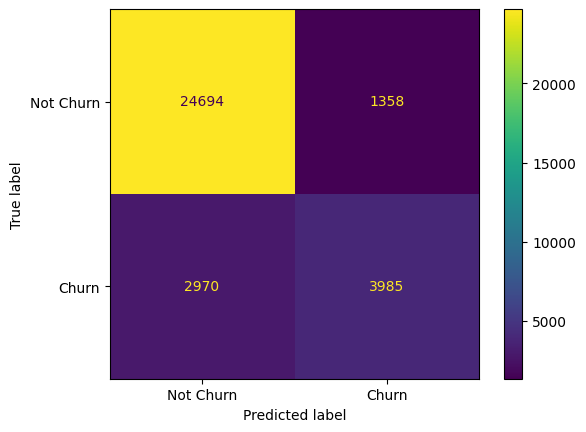

In [31]:
# Assuming trainX and trainy are your features and target variable
X_train, X_val, y_train, y_val = train_test_split(trainX, trainy, test_size=0.2, random_state=42)

cb_pipeline.fit(X = X_train,
                y = y_train)

predictions_cb = cb_pipeline.predict(X_val)

cm_cb = confusion_matrix(y_val, predictions_cb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_cb, display_labels=['Not Churn', 'Churn'])
disp.plot()
plt.show()

**#Confusion Matrix from catboost catboost_params_1:**

* 24699 | 1353
* 2967 | 3988

# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">6. Hyperparameter Tuning with Optuna</p>

## Hyperparameter tuning for XGBoost

In [32]:
# from sklearn.model_selection import  cross_val_score

# def objective_xgb(trial):
#     """Define the objective function for XGBClassifier"""

#     params = {
#         'max_depth': trial.suggest_int('max_depth', 5, 10),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
#         'subsample': trial.suggest_float('subsample', 0.01, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
#         'random_state': trial.suggest_categorical('random_state', [42]),
#         'tree_method': 'hist',  # Use GPU for training
#         'device' : 'cuda',
#         'eval_metric': 'auc',  # Evaluation metric
#         'verbosity': 2,  # Set verbosity to 0 for less output
#     }

#     xgb_model = xgb.XGBClassifier(**params)
#     xgb_pipeline = make_pipeline(modelling_pipeline, xgb_model)

#     # Assuming 'trainX' and 'trainy' are your training data
#     cv = abs(cross_val_score(xgb_pipeline, trainX, trainy, cv=skf, scoring='roc_auc').mean())

    
#     return cv


# # Assuming 'skf' is your StratifiedKFold object
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective_xgb, n_trials=50)

# # Get the best parameters
# best_params_xgb = study.best_params
# print("Best Hyperparameters for XGBoost:", best_params_xgb)

* **Best Hyperparameters for XGBoost: {'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.07353564842520434, 'n_estimators': 463, 'subsample': 0.8131149969184862, 'colsample_bytree': 0.6598001508811656, 'random_state': 42}**

## Hyperparameter tuning for LGBM

In [33]:
# # Assuming 'skf' is your StratifiedKFold object
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# def objective_lgbm(trial):
#     """Define the objective function for LGBMClassifier"""

#     params = {
#         'objective': 'binary',  # Objective for binary classification
#         'boosting_type': 'gbdt',
#         'device': 'gpu',
#         'metric': 'auc',  # Evaluation metric
#         'max_depth': trial.suggest_int('max_depth', 5, 10),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
#         'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
#         'random_state': 42,
#     }

#     lgb_model = lgb.LGBMClassifier(**params)
#     lgb_pipeline = make_pipeline(modelling_pipeline, lgb_model)

#     # Assuming 'trainX' and 'trainy' are your training data
#     cv = abs(cross_val_score(lgb_pipeline, trainX, trainy, cv=skf, scoring='roc_auc').mean())

#     return cv

# # Create an Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective_lgbm, n_trials=50)

# # Get the best parameters
# best_params_lgb = study.best_params
# print("Best Hyperparameters for LGBM:", best_params_lgb)


* **Best Hyperparameters for LGBM:**  {'max_depth': 5, 'min_child_samples': 19, 'learning_rate': 0.0617049347085071, 'n_estimators': 637, 'subsample': 0.7452068722516583, 'colsample_bytree': 0.5621023734368561, 'reg_alpha': 0.5354115365654548, 'reg_lambda': 0.25902660973347336}

## Hyperparameter tuning for CatBoost

In [34]:
# #catboost parameters
# catboost_params_1 = {
#     'iterations': 848, 
#     'depth': 28,
#     'min_data_in_leaf': 5,
#     'learning_rate': 0.027876808218320774,
#     'grow_policy': 'Lossguide',
#     'bootstrap_type': 'Bernoulli',
#     'eval_metric': 'AUC',  
# }

In [35]:
# # Suppress FutureWarnings related to is_sparse
# warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

# # Assuming 'skf' is your StratifiedKFold object
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 1000),
#         'depth': trial.suggest_int('depth', 10, 50),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2, log=True),
#     }
    
#     cb_model = CatBoostClassifier(**params, random_state=42, grow_policy='Lossguide', verbose=0)
#     cb_pipeline = make_pipeline(modelling_pipeline, cb_model)
    

#     cv = abs(cross_val_score(cb_pipeline, trainX, trainy, cv=skf, scoring='roc_auc').mean())
#     return cv

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# best_params_cb = study.best_params
# print("Best Hyperparameters for CatBoost:", best_params_cb)

* **Best Hyperparameters for CatBoost:** {'iterations': 440, 'depth': 7, 'min_data_in_leaf': 25, 'learning_rate': 0.0003089932009656744}. Best is trial 0 with value: 0.8935675084898207.

# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">7. Setting up the Ensemble</p>


In [36]:
from sklearn.ensemble import VotingClassifier

In [37]:
# Ensemble using a VotingClassifier
# {'weight_xgb': 0.3745401188473625, 'weight_lgb': 0.9507143064099162, 'weight_cb': 0.7319939418114051}. Best is trial 0 with value: 0.894922718883933.

ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_pipeline),
    ('lgb', lgbm_pipeline),
    ('cb', cb_pipeline)
        
]
                                  , voting='soft',
                                  weights = [0.4,0.5,0.1])

ensemble_model

VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('pipeline',
                                               Pipeline(steps=[('kmeans',
                                                                KMeansClusterer(features=['CustomerId',
                                                                                          'EstimatedSalary',
                                                                                          'Balance'],
                                                                                n_clusters=10,
                                                                                n_components=3,
                                                                                random_state=123)),
                                                               ('surname_tfid',
                                                                TFIDFPCATransformer(column='Surname',
                                                                                    max_features=1000,
                                                                                    n_components=5)),
                                                               ('age_binning',
                                                                AgeBinning(n_bins=5)),
                                                               ('salary_binning',
                                                                S...
                                                                ColumnTransformer(remainder='passthrough',
                                                                                  transformers=[('encode',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse_output=False),
                                                                                                 ['Gender',
                                                                                                  'Geography',
                                                                                                  'NumOfProducts',
                                                                                                  'HasCrCard',
                                                                                                  'IsActiveMember',
                                                                                                  'Geo_Gender',
                                                                                                  'Tp_Gender'])])),
                                                               ('scale',
                                                                RobustScaler())])),
                                              ('catboostclassifier',
                                               <catboost.core.CatBoostClassifier object at 0x7827d29172b0>)]))],
                 voting='soft', weights=[0.4, 0.5, 0.1])

In [38]:
# # number of folds
# n_splits = 10

# #  StratifiedKFold
# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# #  cross-validation results
# cv_results = []

# # stratified k-fold cross-validation
# for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

#     ensemble_model.fit(X_train, y_train )

#     # predictions on the validation set
#     y_val_pred_prob = ensemble_model.predict(X_val)
#     y_pred = ensemble_model.predict(X_val)
        
#     f1=  f1_score(y_val, y_pred, average='weighted')

#     # Evaluating the model
    
#     roc_auc = roc_auc_score(y_val, y_val_pred_prob)
#     print(f'Fold {fold + 1}, AUC Score on Validation Set: {roc_auc}')
#     print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
#     print('-'*70)

#     # results
#     cv_results.append(roc_auc)

# # average cross-validation result
# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage AUC-score across {n_splits} folds: {average_cv_result}')

*** Ensemble Model (baseline 1,1,1) Results:**

Fold 1, AUC Score on Validation Set: 0.7614829240362847
Fold 1, F1 Score on Validation Set: 0.8641206229401505
----------------------------------------------------------------------
Fold 2, AUC Score on Validation Set: 0.7515675458973635
Fold 2, F1 Score on Validation Set: 0.856688605977892
----------------------------------------------------------------------
Fold 3, AUC Score on Validation Set: 0.7541521721600538
Fold 3, F1 Score on Validation Set: 0.8590412579437448
----------------------------------------------------------------------
Fold 4, AUC Score on Validation Set: 0.7557493963959189
Fold 4, F1 Score on Validation Set: 0.8598038536226197
----------------------------------------------------------------------
Fold 5, AUC Score on Validation Set: 0.7557078652189886
Fold 5, F1 Score on Validation Set: 0.8600757772751055
----------------------------------------------------------------------
Fold 6, AUC Score on Validation Set: 0.7639257332085644
Fold 6, F1 Score on Validation Set: 0.8655059960363871
----------------------------------------------------------------------
Fold 7, AUC Score on Validation Set: 0.7632476788738897
Fold 7, F1 Score on Validation Set: 0.8637776146854188
----------------------------------------------------------------------
Fold 8, AUC Score on Validation Set: 0.7573776788395545
Fold 8, F1 Score on Validation Set: 0.862168271476127
----------------------------------------------------------------------
Fold 9, AUC Score on Validation Set: 0.7598912471894651
Fold 9, F1 Score on Validation Set: 0.8612356762440299
----------------------------------------------------------------------
Fold 10, AUC Score on Validation Set: 0.7570281200073635
Fold 10, F1 Score on Validation Set: 0.861166780527565
----------------------------------------------------------------------

Average AUC-score across 10 folds: 0.7580130361827446

*** Ensemble Model {'weight_xgb': 0.3745401188473625, 'weight_lgb': 0.9507143064099162, 'weight_cb': 0.7319939418114051} Results:**


Fold 1, AUC Score on Validation Set: 0.7618530115297572
Fold 1, F1 Score on Validation Set: 0.8640007358998513
----------------------------------------------------------------------
Fold 2, AUC Score on Validation Set: 0.7525419306313073
Fold 2, F1 Score on Validation Set: 0.8572935205852342
----------------------------------------------------------------------
Fold 3, AUC Score on Validation Set: 0.7555524568210716
Fold 3, F1 Score on Validation Set: 0.8593557820513934
----------------------------------------------------------------------
Fold 4, AUC Score on Validation Set: 0.7558646834607102
Fold 4, F1 Score on Validation Set: 0.8599655467086817
----------------------------------------------------------------------
Fold 5, AUC Score on Validation Set: 0.7573597518990672
Fold 5, F1 Score on Validation Set: 0.8609960557006606
----------------------------------------------------------------------
Fold 6, AUC Score on Validation Set: 0.7630666266793549
Fold 6, F1 Score on Validation Set: 0.8650651750166936
----------------------------------------------------------------------
Fold 7, AUC Score on Validation Set: 0.7637819875384324
Fold 7, F1 Score on Validation Set: 0.8640161430232965
----------------------------------------------------------------------
Fold 8, AUC Score on Validation Set: 0.7574650685476022
Fold 8, F1 Score on Validation Set: 0.8624189361923639
----------------------------------------------------------------------
Fold 9, AUC Score on Validation Set: 0.7609877618752939
Fold 9, F1 Score on Validation Set: 0.8616251841374007
----------------------------------------------------------------------
Fold 10, AUC Score on Validation Set: 0.7589558438656584
Fold 10, F1 Score on Validation Set: 0.8620918477700645
----------------------------------------------------------------------

Average AUC-score across 10 folds: 0.7587429122848255

In [39]:
# # Assuming trainX and trainy are your features and target variable
# X_train, X_val, y_train, y_val = train_test_split(trainX, trainy, test_size=0.2, random_state=42)

# ensemble_model.fit(X = X_train, y = y_train)

# predictions_ensemble = ensemble_model.predict(X_val)

# cm_ensemble = confusion_matrix(y_val, predictions_ensemble)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=['Not Churn', 'Churn'])
# disp.plot()
# plt.show()

**#Confusion Matrix from Ensemble Model (baseline 1,1,1):**

* 24739 | 1313
* 2970 | 3985

**#Confusion Matrix from Ensemble Model {'weight_xgb': 0.3745401188473625, 'weight_lgb': 0.9507143064099162, 'weight_cb': 0.7319939418114051}:**

* 24717 | 1335
* 2957 | 3998

# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">8. Hyperparameter Tuning for Ensemble Weight</p>


In [40]:
# # Define the parameter search space
# def objective(trial):
#     weights = [
#         trial.suggest_float('weight_xgb', 0, 1),  # Adjust the range based on your expectations
#         trial.suggest_float('weight_lgb', 0, 1),
#         trial.suggest_float('weight_cb', 0, 1)
#     ]

#     ensemble_model = VotingClassifier(
#         estimators=[
#             ('xgb', xgb_pipeline),
#             ('lgb', lgbm_pipeline),
#             ('cb', cb_pipeline)
#         ], voting='soft', weights=weights)

#     # Assuming 'trainX' and 'trainy' are your training data
#     cv = abs(cross_val_score(ensemble_model, trainX, trainy, cv=skf, scoring='roc_auc').mean())

#     return cv

# # Assuming 'skf' is your StratifiedKFold object
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # Use the 'sampler' parameter for parallelization
# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
# study.optimize(objective, n_trials=50)

# best_weights = study.best_params
# print("Best Weights for Ensemble:", best_weights)


* Trial 1 finished with value: 0.8947827272920067 and parameters: {'weight_xgb': 0.5986584841970366, 'weight_lgb': 0.15601864044243652, 'weight_cb': 0.15599452033620265}. Best is trial 0 with value: 0.8949226492021898.



* Trial 0 finished with value: 0.894922718883933 and parameters: {'weight_xgb': 0.3745401188473625, 'weight_lgb': 0.9507143064099162, 'weight_cb': 0.7319939418114051}. Best is trial 0 with value: 0.894922718883933.
* Trial 1 finished with value: 0.8948201194071821 and parameters: {'weight_xgb': 0.5986584841970366, 'weight_lgb': 0.15601864044243652, 'weight_cb': 0.15599452033620265}. Best is trial 0 with value: 0.894922718883933.
* Trial 2 finished with value: 0.8948752164576543 and parameters: {'weight_xgb': 0.05808361216819946, 'weight_lgb': 0.8661761457749352, 'weight_cb': 0.6011150117432088}. Best is trial 0 with value: 0.894922718883933.
* Trial 3 finished with value: 0.8944471339057675 and parameters: {'weight_xgb': 0.7080725777960455, 'weight_lgb': 0.020584494295802447, 'weight_cb': 0.9699098521619943}. Best is trial 0 with value: 0.894922718883933.
* Trial 4 finished with value: 0.894827628230162 and parameters: {'weight_xgb': 0.8324426408004217, 'weight_lgb': 0.21233911067827616, 'weight_cb': 0.18182496720710062}. Best is trial 0 with value: 0.894922718883933.
* Trial 5 finished with value: 0.8947256695087843 and parameters: {'weight_xgb': 0.18340450985343382, 'weight_lgb': 0.3042422429595377, 'weight_cb': 0.5247564316322378}. Best is trial 0 with value: 0.894922718883933.
* Trial 6 finished with value: 0.8948473714675028 and parameters: {'weight_xgb': 0.43194501864211576, 'weight_lgb': 0.2912291401980419, 'weight_cb': 0.6118528947223795}. Best is trial 0 with value: 0.894922718883933.

In [41]:
# # Define the parameter grid for weights
# param_grid = {'weights': [(round(w1, 2), round(w2, 2), round(w3, 2))
#                            for w1 in np.arange(0.0, 1.0, 0.1)
#                            for w2 in np.arange(0.0, 1.0, 0.1)
#                            for w3 in np.arange(0.0, 1.0, 0.1)
#                            if round(w1 + w2 + w3, 2) == 1.0]}

# # Extract weights from the parameter grid
# weights_combinations = param_grid['weights']

# # Display the combinations
# for combination in weights_combinations:
#     print(combination)

In [42]:
# import itertools
# import numpy as np

# # Define the possible values for weights
# weights_range = np.arange(0.0, 1.1, 0.1)

# # Generate all possible combinations of weights
# weight_combinations = itertools.product(weights_range, repeat=3)

# # Filter combinations where the sum is 1.0
# valid_weight_combinations = [weights for weights in weight_combinations if round(sum(weights), 2) == 1.0]

# # Display the combinations
# for combination in valid_weight_combinations:
#     print(combination)

In [43]:
# # Define the parameter grid for weights
# param_grid = {'weights': [(round(w1, 2), round(w2, 2), round(w3, 2))
#                            for w1 in np.arange(0.0, 1.0, 0.1)
#                            for w2 in np.arange(0.0, 1.0, 0.1)
#                            for w3 in np.arange(0.0, 1.0, 0.1)
#                            if round(w1 + w2 + w3, 2) == 1.0]}

# # Create the VotingClassifier
# ensemble_model = VotingClassifier(estimators=[
#     ('xgb', xgb_pipeline),
#     ('lgb', lgbm_pipeline),
#     ('cb', cb_pipeline)
# ], voting='soft')

# # Create a StratifiedKFold instance
# stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# # Perform grid search
# grid_search = GridSearchCV(estimator=ensemble_model,
#                            param_grid=param_grid,
#                            scoring='roc_auc',
#                            cv=stratified_kfold,
#                            verbose=2)
                           
# # Fit the grid search
# grid_search.fit(trainX, trainy)

# # Get the best weights
# best_weights = grid_search.best_params_['weights']
# best_weights

# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">9. Review of Features</p>

## XGB Feature Importance

In [44]:
# Access individual base models' feature importances (if available)
xgb_feature_importance = xgb_pipeline.named_steps['xgbclassifier'].feature_importances_

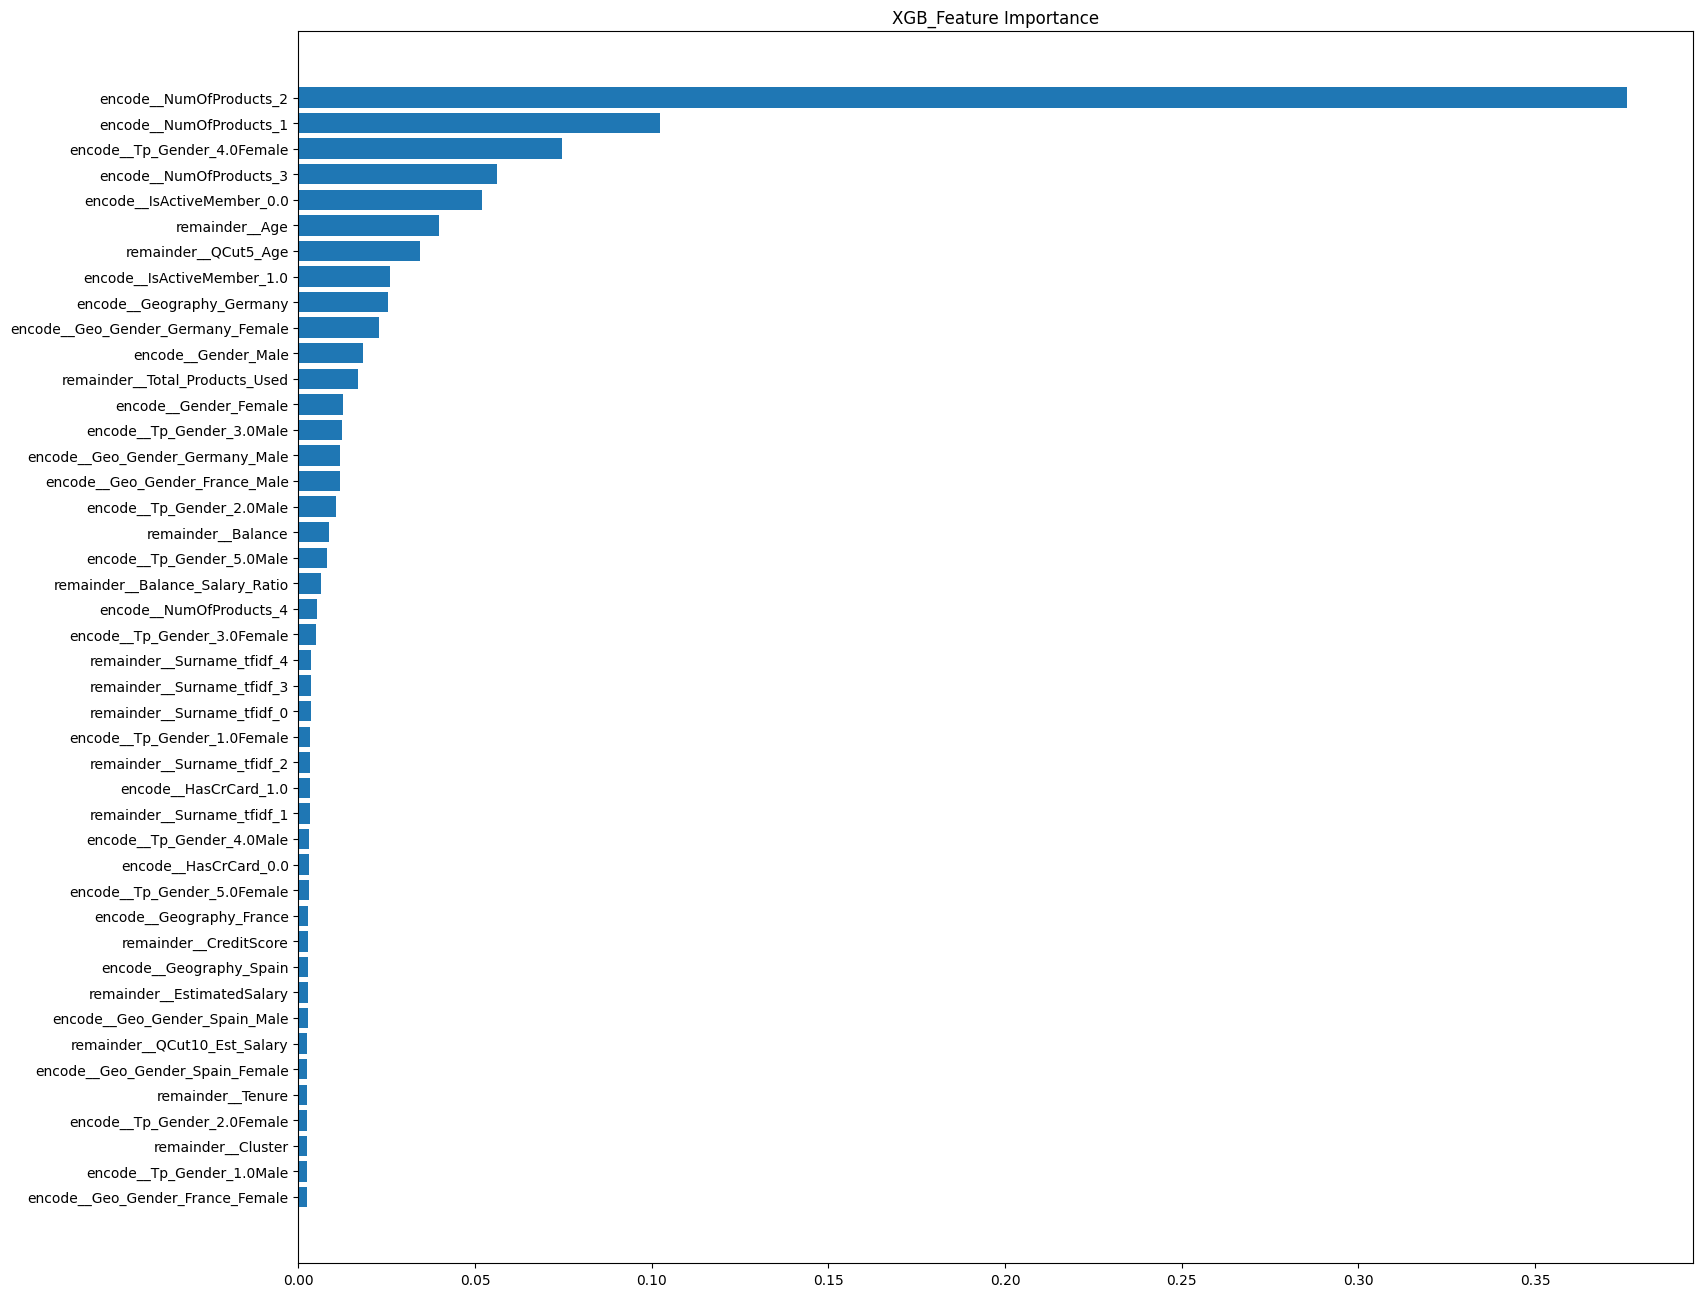

In [45]:
train_X = modelling_pipeline.fit_transform(train.drop(['Exited'], axis=1))


sorted_idx = np.argsort(xgb_feature_importance)
fig = plt.figure(figsize=(18, 16))
plt.barh(range(len(sorted_idx)), xgb_feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_X.columns)[sorted_idx])
plt.title('XGB_Feature Importance')
plt.show()


## LGBM Feature Importance

In [46]:
# Access individual base models' feature importances (if available)
lgbm_feature_importance = lgbm_pipeline.named_steps['lgbmclassifier'].feature_importances_

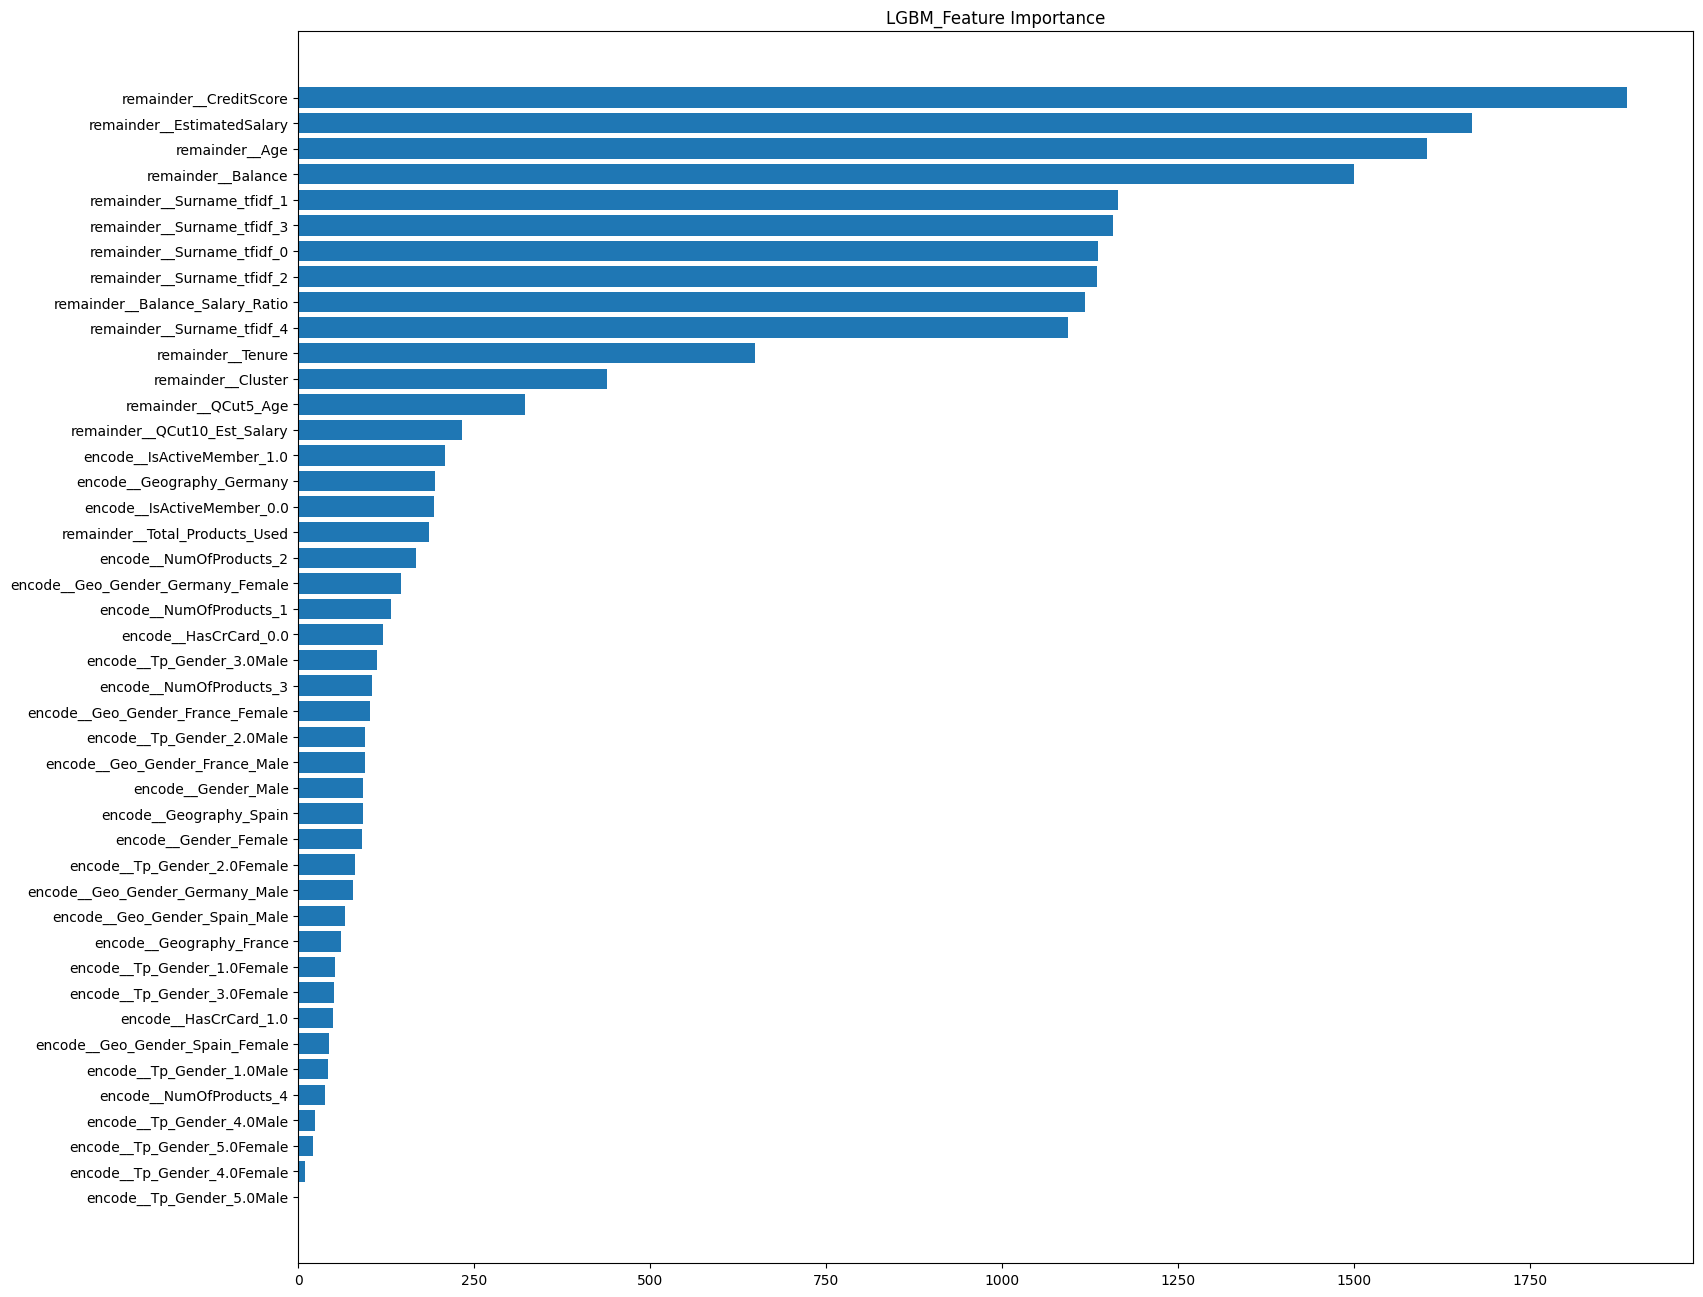

In [47]:
sorted_idx = np.argsort(lgbm_feature_importance)
fig = plt.figure(figsize=(18, 16))
plt.barh(range(len(sorted_idx)), lgbm_feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_X.columns)[sorted_idx])
plt.title('LGBM_Feature Importance')
plt.show()


## CatBoost Feature Importance

In [48]:
# Access individual base models' feature importances (if available)
cb_feature_importance = cb_pipeline.named_steps['catboostclassifier'].feature_importances_

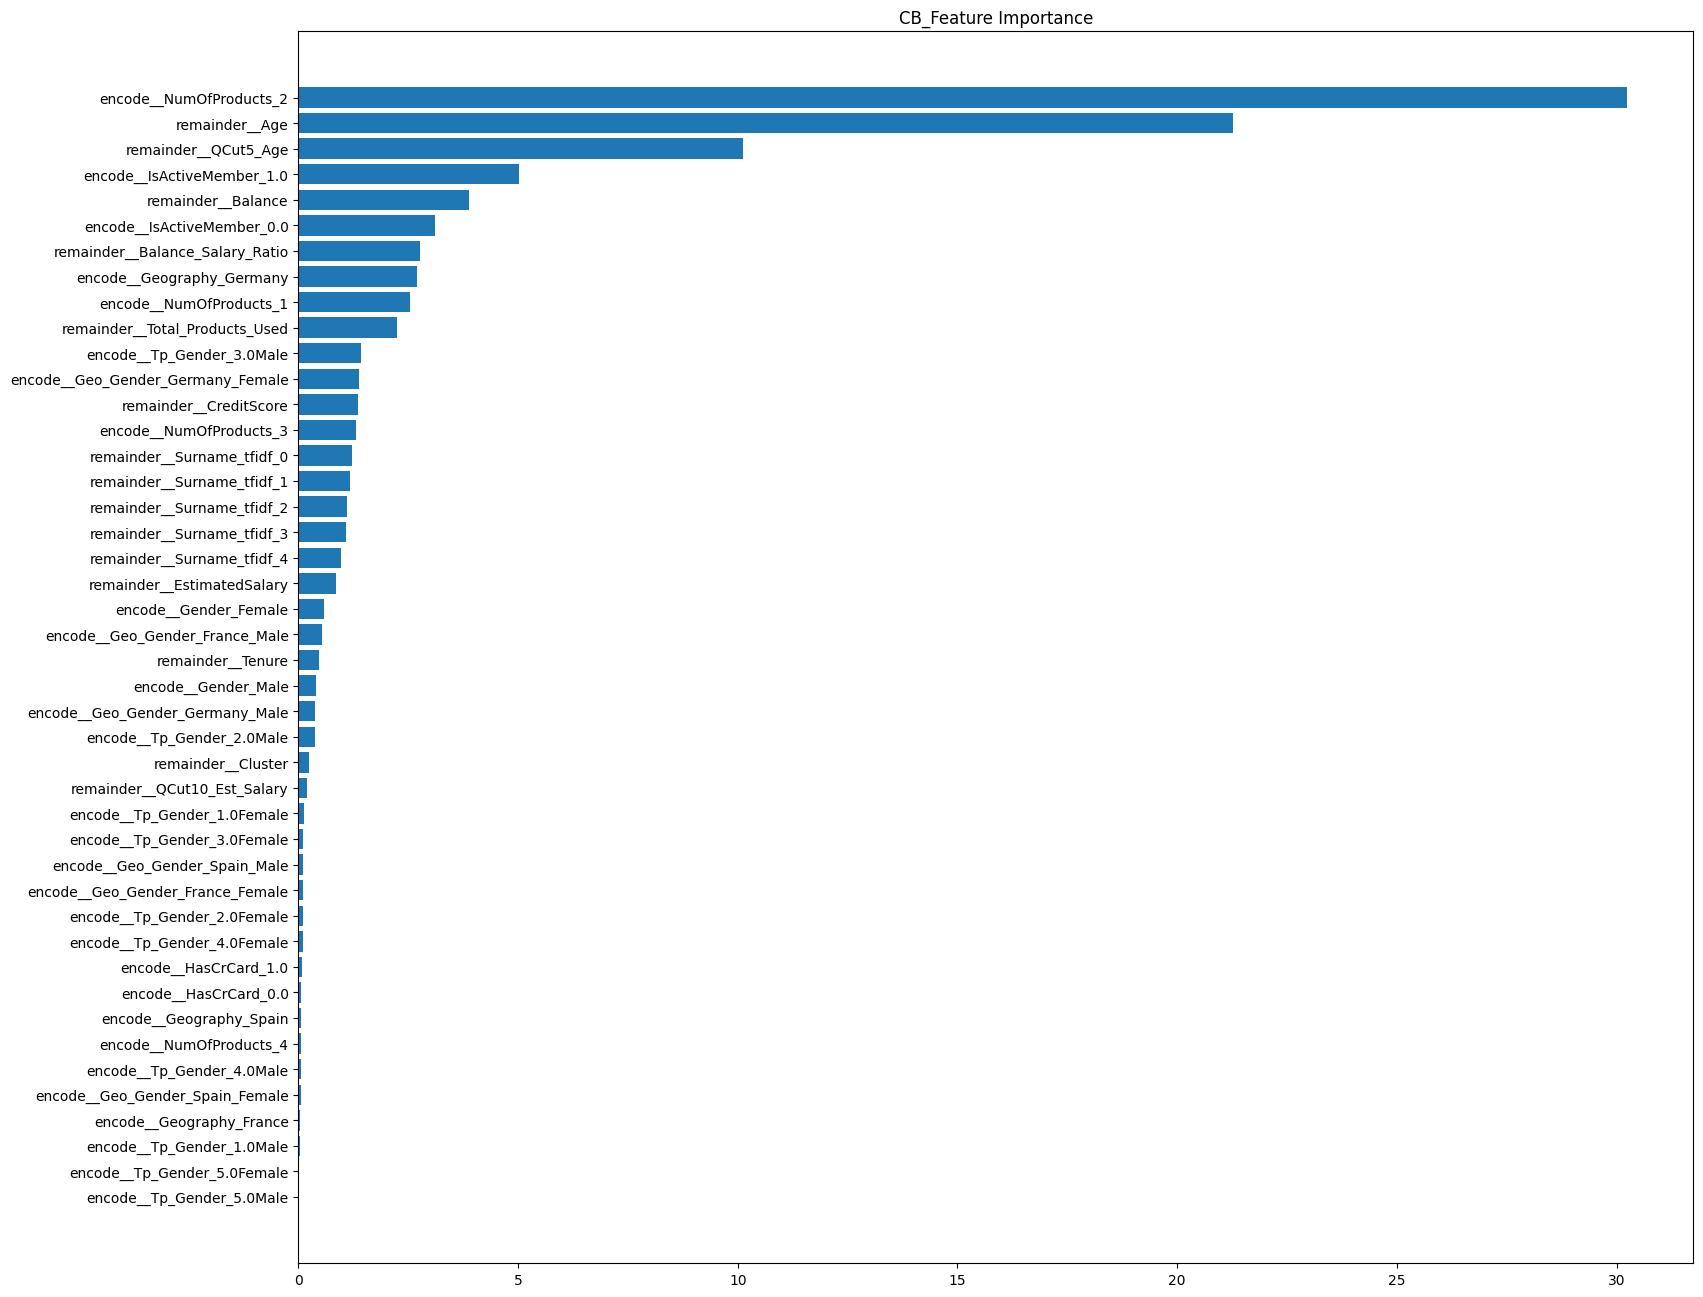

In [49]:
sorted_idx = np.argsort(cb_feature_importance)
fig = plt.figure(figsize=(18, 16))
plt.barh(range(len(sorted_idx)), cb_feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_X.columns)[sorted_idx])
plt.title('CB_Feature Importance')
plt.show()

# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">10. Submission</p>

In [50]:
# # Fit the ensemble baseline model
# ensemble_model.fit(X=train.drop(['Exited'], axis=1), y=train['Exited'])

# # Create submission file with probability predictions
# predictions = ensemble_model.predict_proba(test)[:, 1]  # Use the probabilities of class 1

# sample['Exited'] = predictions
# sample.to_csv('submission_ensemble_baseline.csv', index=False)


In [51]:
# Fit the ensemble final model
ensemble_model.fit(X=train.drop(['Exited'], axis=1), y=train['Exited'])

# Create submission file with probability predictions
predictions = ensemble_model.predict_proba(test)[:, 1]  # Use the probabilities of class 1

sample['Exited'] = predictions
sample.to_csv('submission_ensemble_final.csv', index=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [52]:
sample.head()

,id,Exited
0,165034,0.016560
1,165035,0.720894
2,165036,0.034957
3,165037,0.221327
4,165038,0.392796
